**TP 2 TSIA 202_B: Spectral Estimation**

In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, lfilter
import librosa

**1.1**

In [3]:
def AR_process(N, coeffs, sigma):
    
    p = len(coeffs)  #order of the AR process

    data = np.zeros(N + 10*p) #on initialise le AR process, on rajoute 10*p valeurs afin de ne pas être gêné par la causalités du filtre

    # Generate white noise
    noise = np.random.normal(0, sigma, N + 10*p)

    for t in range (0, N + 10*p): 

        if (t >= p):
            data[t] = noise[t] + np.dot(coeffs[::-1], data[t - p:t])    
        else: 
            data[t] = noise[t] + np.dot(coeffs[p - t:t:-1], data[:t])

    return data[10*p:]

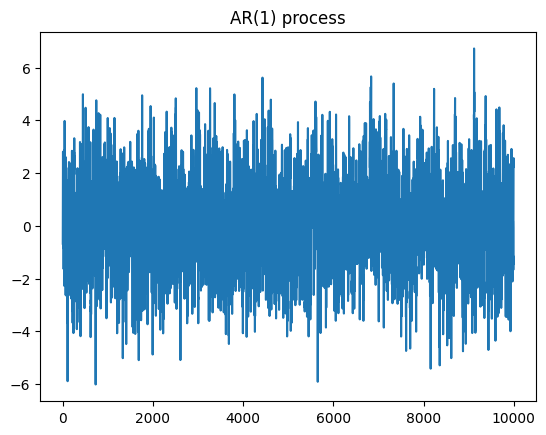

In [4]:
#test with an AR(1) process
coeffs_test = [0.8]
sigma2_test = 1
signal = AR_process(10000, coeffs = coeffs_test, sigma = sigma2_test)
N_test = len(signal)
M_test = int(np.sqrt(N_test))

plt.plot(signal)
plt.title("AR(1) process")
plt.show()

**1.2**

In [5]:
#compute the theorical psd of a AR(1) signal of variance sigma^2 and defined by the coefficient coeff
def psd_ar1(sigma2, coeffs, M):
    """
    Input : 
    Coeffs : coeffs of the AR process
    sigma2 : Variance 
    M : step for frequencies"""
    coeff = coeffs[0]
    f = np.fft.fftfreq(M)
    psd = sigma2 / np.abs(1 - coeff * np.exp(-2j * np.pi * f))**2
    return psd, f

In [6]:
def periodogram(X, method: {'Std', 'B', 'W'}):

    N = len(X) #len of the samples

    #Barlett method
    M = int(np.sqrt(N)) #size of the sub_samples
    L = N // M #nb of sub_samples
    f = [] 
  

    #Welch method
    K = M // 2
    S = 2 * N // M - 1

    if (method == 'Std'):

         f, Pxx = np.fft.fftfreq(N), 1/N * np.abs(np.fft.fft(X))**2

    elif method == 'B':

        f =  np.fft.fftfreq(N)
        Pxx = np.zeros_like(f)
        for i in range(L):#on effectue L fft of samples of size M 
            Pxx_int = 1/(L*M) * np.abs(np.fft.fft(X[i*M:(i + 1)*M], n=N))**2
            Pxx = Pxx + Pxx_int
        
 
    elif method == 'W':
        P = np.sum(np.hamming(M)**2) / M
        f =  np.fft.fftfreq(N)
        Pxx = np.zeros_like(f)
        for i in range(S):#on effectue S fft of samples of size M
            Pxx +=  np.abs(np.fft.fft(X[i*K:i*K + M] * np.hanning(M), n=N)**2) / (M*P*S)
                   
    return f, Pxx

#plot the periodogram computed with the chosen method, and the psd on the same plot
def visualisation(f, Pxx, method: {'Std', 'B', 'W'}, psd):
    
    #f, Pxx = f[f>=0], Pxx[f>=0] 
    f = np.fft.fftshift(f)
    Pxx = np.fft.fftshift(Pxx)
    """
    #calculate the PSD for the AR(1) process chosen
    psd, fth = psd_ar1(sigma2_test, coeffs_test, N_test)
    #psd, fth = psd[fth>=0], fth[fth>=0] 
    """
    #fth = np.fft.fftshift(fth)
    psd = np.fft.fftshift(psd)
    
    #computation of the bias and variance of each estimator
    bias = np.mean(Pxx - psd)
    variance = np.var(Pxx)
    print("the bias of the", method, "estimator is:", bias,"and its variance is", variance)
    
    plt.figure(figsize=(10, 6))
    #plt.plot(f, Pxx, color='red', label=method)
    #plt.plot(fth, psd, color='blue', label="PSD")
    plt.plot(f, 10*np.log10(psd), color='blue', label="PSD")
    plt.plot(f, 10*np.log10(Pxx), color='red', alpha = 0.5, label=method)
    plt.xlabel('Normalized frequency')
    plt.ylabel('Power Spectral Density (dB)')
    if (method == 'Std'):
        plt.title('Periodogram computed using the standard method')
    elif (method == 'B'):
        plt.title('Periodogram computed using the Barlett method')
    elif (method == 'W'):
        plt.title('Periodogram computed using the Welch method')
    #plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()



        


**3.**

the bias of the Std estimator is: -0.11352934968591373 and its variance is 53.96089832044728


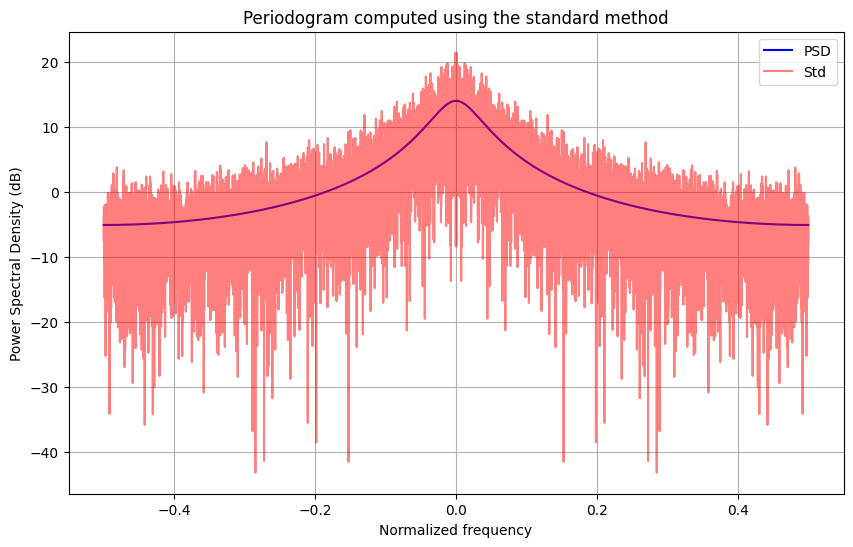

the bias of the B estimator is: -0.11352934968591376 and its variance is 22.573512956880716


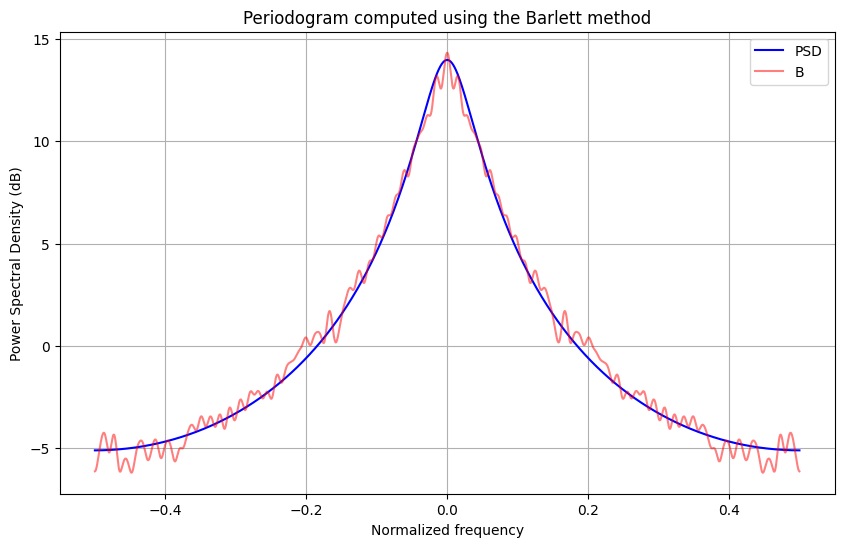

the bias of the W estimator is: -0.2900237507182474 and its variance is 19.681572848996346


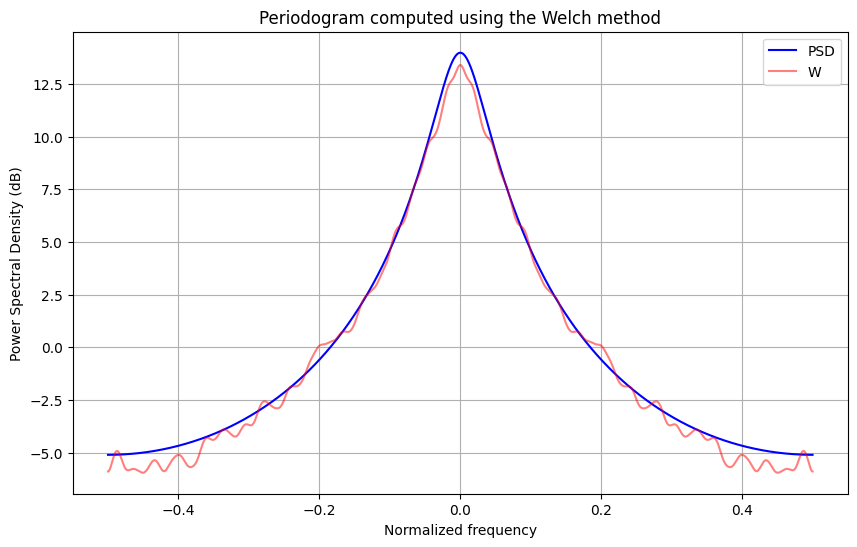

In [7]:
#test
for i in({'Std', 'B', 'W'}):
    f, Pxx = periodogram(signal, method=i)

    #calculate the PSD for the AR(1) process chosen
    psd, _ = psd_ar1(sigma2_test, coeffs_test, N_test)
    
    visualisation(f, Pxx, method=i, psd=psd)   

**4.**

As expected, the periodogram computed using the standard method have a small bias, but have a big standard deviation. The two others methods have a bigger bias, but a smaller standard deviation.

**1.3**

**5.**

In [37]:
coeffs_est = - librosa.lpc(signal, order = 1)[1:]
sigma_est = librosa.feature.rms(y=signal)[0,0]
#sigma_est = np.var(signal)
#sigma_est = 1
print("estimated coeffs:", coeffs_est, "estimated variance: ", sigma_est**2)
print("l'erreur relative sur les coeffs est de:", np.abs(coeffs_test[0] - coeffs_est[0]) / coeffs_test[0])

estimated coeffs: [0.79281792] estimated variance:  1.4688090872805901
l'erreur relative sur les coeffs est de: 0.008977602455018663


L'erreur sur la variance est assez abérante, on devrait utiliser une autre méthode pour estimer la variance de manière plus précise.

**6.**

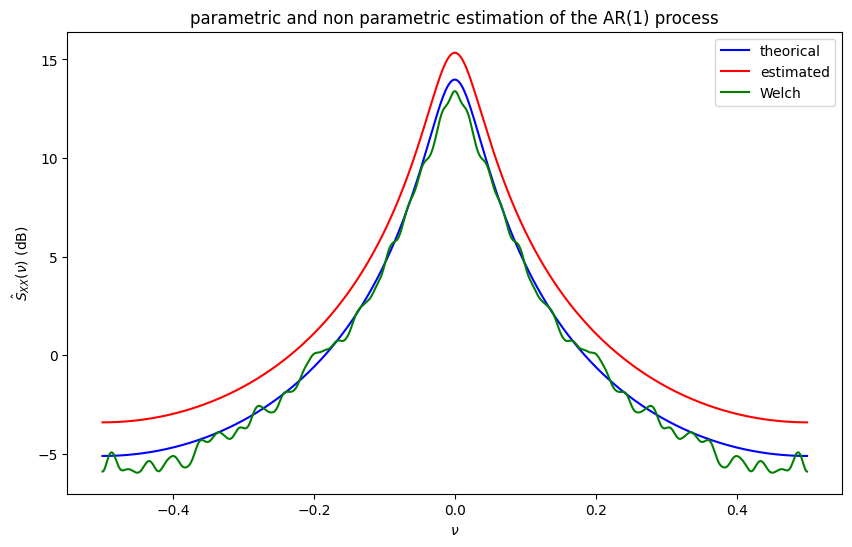

In [38]:
plt.figure(figsize=(10, 6))

#theorical PSD of the AR process
psd, f = psd_ar1(sigma2_test, coeffs_test, N_test)
f = np.fft.fftshift(f)
psd = np.fft.fftshift(psd)
plt.plot(f, 10*np.log10(psd), color='blue', label="theorical")

#psd of the estimated AR process
psd_est, f_est = psd_ar1(sigma_est**2, coeffs_est, N_test)
f_est = np.fft.fftshift(f_est)
psd_est = np.fft.fftshift(psd_est)
plt.plot(f_est, 10*np.log10(psd_est), color='red', label="estimated")

#periodram using Welch's method
f_w, Pxx = periodogram(signal, method='W')
f_w = np.fft.fftshift(f_w)
Pxx = np.fft.fftshift(Pxx)
plt.plot(f_w, 10*np.log10(Pxx), color='green', label="Welch")

plt.title("parametric and non parametric estimation of the AR(1) process")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\hat{S}_{XX}(\nu)$ (dB)")
plt.legend()
plt.show()

The linear prediction has a good shape, but there is a noticeable bias. This can be explained by the bad estimation of the variance of the AR process, we tried with sigma2_est = 1 and the linear prediction perfectly fited the theorical PSD. 


**1.4**

**7.**

Forme du signal : (59964,)
Taux d'échantillonnage : 11025


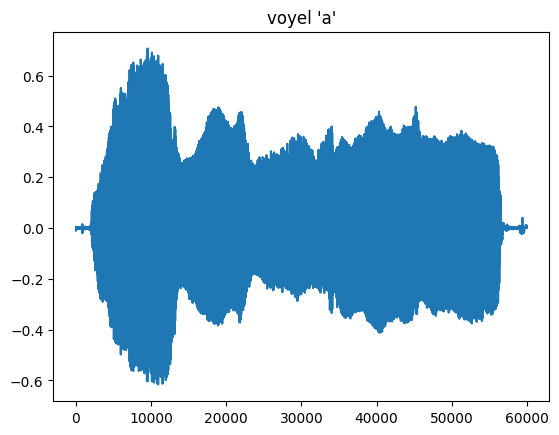

In [39]:
#Extraction du fichier audio
# Chemin vers le fichier audio
audio_file_path = r'sounds\aeiou.wav'

# Charger le fichier audio avec Librosa
audio_signal, sample_rate = librosa.load(audio_file_path, sr=None)

# Afficher la forme du signal
print("Forme du signal :", audio_signal.shape)
print("Taux d'échantillonnage :", sample_rate)

plt.plot(audio_signal)
plt.title("voyel 'a'")
plt.show()

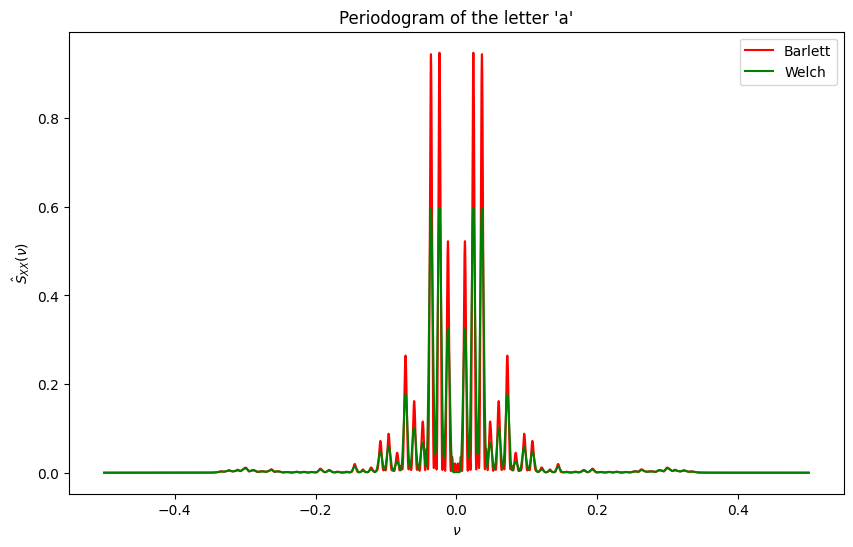

In [11]:
plt.figure(figsize=(10, 6))

#periodram 
for i in({'B', 'W'}):
    f_w, Pxx = periodogram(audio_signal, method=i)
    f_w = np.fft.fftshift(f_w)
    Pxx = np.fft.fftshift(Pxx)
    if (i=='Std'):
        plt.plot(f_w, Pxx, color='blue', label="Standard")
    elif (i=='W'):
        plt.plot(f_w, Pxx, color='green', label="Welch")
    elif (i=='B'):
        plt.plot(f_w, Pxx, color='red', label="Barlett")

plt.title("Periodogram of the letter 'a'")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\hat{S}_{XX}(\nu)$")
#plt.yscale("log")
plt.legend()
plt.show()

We are able to the see harmonics that compose the letter a.

**2.1**

In [12]:
def synthesize_sum_sinus(N, freqs, amp, phiO, sigma2):

    signal = np.zeros(N)
    K = len(amp)
    for i in range(N): 
        for j in range(K): 
            signal[i] += amp[j]*np.sin(2*np.pi*freqs[j]*i + phiO[j])
    signal += np.random.normal(0, np.sqrt(sigma2), N)
    
    return signal 


**2.2**

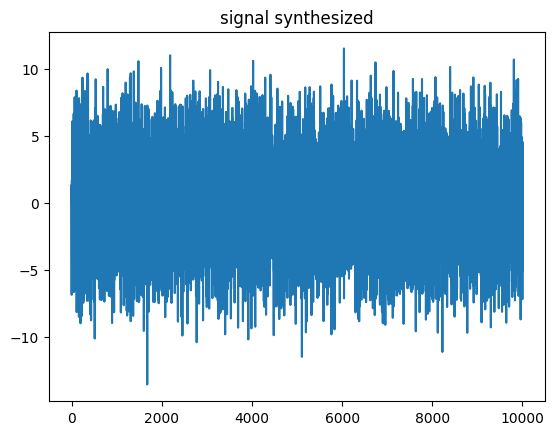

In [42]:
N_sin = 10000
freqs_sin = np.array([0.20, 0.40])
amp_sin = np.ones(2)
phiO_sin = np.zeros(2)
sigma2_sin = 10
signal_sin = synthesize_sum_sinus(N=N_sin, freqs=freqs_sin, amp=amp_sin, phiO=phiO_sin, sigma2=sigma2_sin)

plt.plot(signal_sin)
plt.title("signal synthesized")
plt.show()

In [43]:
def periodogram_sin(freqs, signal, sigma2):
    plt.figure(figsize=(10, 6))

    #periodram 
    for i in({'Std', 'B', 'W'}):
        f_w, Pxx = periodogram(signal, method=i)
        f_w = np.fft.fftshift(f_w)
        Pxx = np.fft.fftshift(Pxx)
        if (i=='Std'):
            plt.plot(f_w, Pxx, color='blue', label="Standard", alpha=0.3)
        elif (i=='W'):
            plt.plot(f_w, Pxx, color='green', label="Welch")
        elif (i=='B'):
            plt.plot(f_w, Pxx, color='red', label="Barlett")

    #tradé des lignes demandées
    plt.axvline(x=freqs[0], color='y', linestyle='--', label='f1')
    plt.axvline(x=freqs[1], color='orange', linestyle='--', label='f2')
    plt.axvline(x=-freqs[0], color='y', linestyle='--', label='- f1')
    plt.axvline(x=-freqs[1], color='orange', linestyle='--', label='- f2')
    plt.axhline(y=sigma2, color='purple', linestyle='--', label='sigma2')

    plt.title("Periodogram of the synthesized signal")
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\hat{S}_{XX}(\nu)$")
    #plt.ylim(-1, 50)
    plt.yscale("log")
    plt.legend()
    plt.show()

Plot with $\sigma^2=10$ and $\Delta |\nu_0 - \nu_1|=0.2$

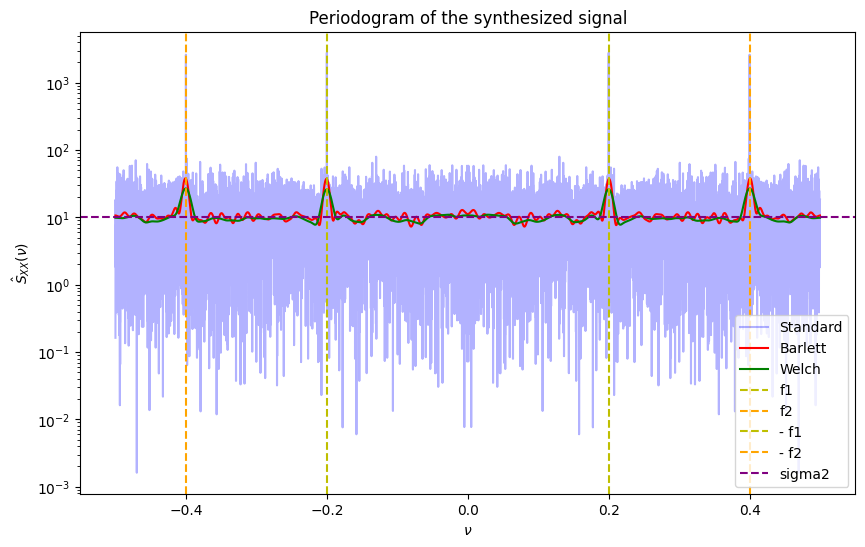

In [44]:
#periodogram of the previously synthesized signal: high noise, 2 distincts frequencies
periodogram_sin(freqs_sin, signal_sin, sigma2_sin)

We can see that each method works well

Plot with $\sigma^2=100$ and $\Delta |\nu_0 - \nu_1|=0.2$

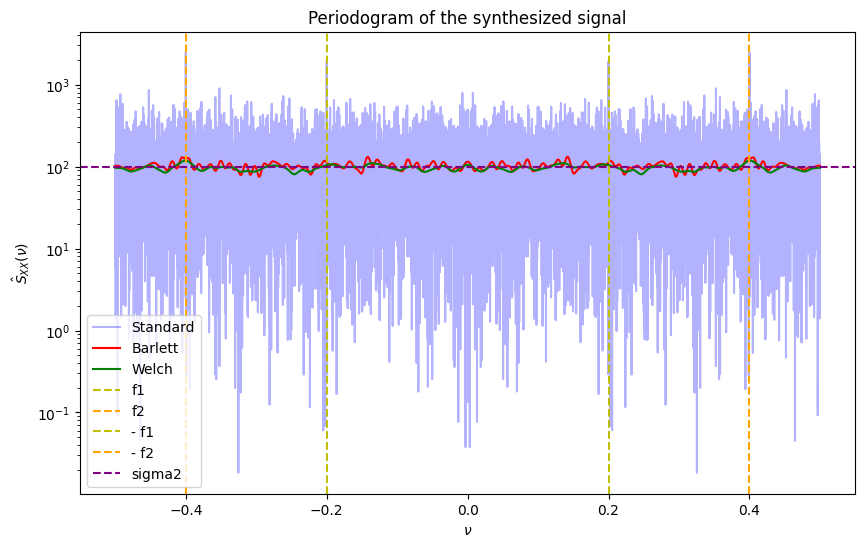

In [45]:
#periodogram of the previously synthesized signal: high noise, 2 distincts frequencies
periodogram_sin(freqs_sin, synthesize_sum_sinus(N=N_sin, freqs=[0.2,0.4], amp=amp_sin, phiO=phiO_sin, sigma2=100), 100)

We can see that with a big variance, Welch and Barlett don't work well, however the standard methods is still working.

Plot with $\sigma^2=10$ and $\Delta |\nu_0 - \nu_1|=0.01$

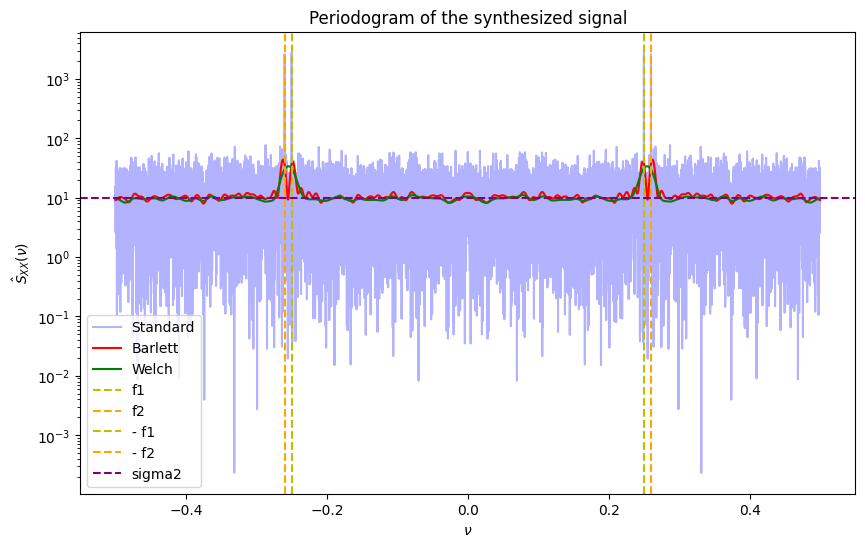

In [46]:
#periodogram of a signal with high noise and close frequencies
signal_sin1 = synthesize_sum_sinus(N=N_sin, freqs=[0.25,0.26], amp=amp_sin, phiO=phiO_sin, sigma2=10)
periodogram_sin(freqs=[0.25,0.26], signal=signal_sin1, sigma2=10)

With $\Delta |\nu_0-\nu_1|=0.01$ Barlett still separeing the two frequencise but Welch don't

Plot with $\sigma^2=10$ and $\Delta |\nu_0 - \nu_1|=0.005$

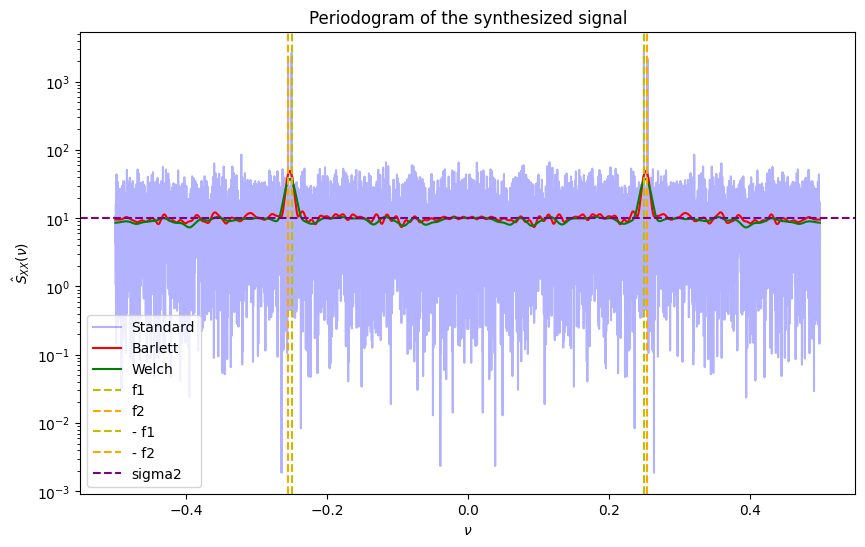

In [47]:
#periodogram of a signal with high noise and really close frequencies
signal_sin2 = synthesize_sum_sinus(N=N_sin, freqs=[0.25,0.255], amp=amp_sin, phiO=phiO_sin, sigma2=10)
periodogram_sin(freqs=[0.25,0.255], signal=signal_sin2, sigma2=10)

With $\Delta |\nu_0-\nu_1|=0.005$ Barlett and Welch methods can't detect 2 distinc frequencies. Still, the standard method detect both of the frequencies.

**2.3**

In [66]:
#estimate a fourth order AR process, using linear prediction model
coeffs_est_4 = - librosa.lpc(signal_sin, order = 4)[1:]
sigma_est_4 = librosa.feature.rms(y=signal_sin)[0,0]
print("estimated coeffs:", coeffs_est_4, "estimated variance: ", sigma_est_4**2)
print("the relative error of the estimation of the variance is:", np.abs(sigma_est_4**2 - sigma2_sin) / sigma2_sin**2)

estimated coeffs: [-0.02335482 -0.01700269 -0.02685254 -0.0396457 ] estimated variance:  5.347731232905971
the relative error of the estimation of the variance is: 0.04652268767094028


Again, Librosa gives us an estimated variance with a huge error. 

In [49]:
def ARestimation(signal, freqs, sigma2, order):

    N = len(signal)

    #estimate a fourth order AR process, using linear prediction model
    coeffs_est = librosa.lpc(signal, order=order)
    sigma_est = librosa.feature.rms(y=signal)[0,0]
  
    print("estimated coeffs:", coeffs_est, "estimated variance: ", sigma_est**2)

    #estimation of the psd of the AR
    psd_est = (sigma_est**2) / np.abs(np.fft.fft(coeffs_est, n=N))**2 
    
    f = np.fft.fftshift(np.fft.fftfreq(N))
    psd_est = np.fft.fftshift(psd_est)
    plt.plot(f, psd_est, c='orange', label="linear prediction")

    #tradé des lignes demandées
    plt.axvline(x=freqs[0], color='y', linestyle='--', label='f1')
    plt.axvline(x=freqs[1], color='orange', linestyle='--', label='f2')
    plt.axvline(x=-freqs[0], color='y', linestyle='--', label='- f1')
    plt.axvline(x=-freqs[1], color='orange', linestyle='--', label='- f2')
    plt.axhline(y=sigma2, color='purple', linestyle='--', label='sigma2')

    plt.title("Periodogram of the synthesized signal")
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\hat{S}_{XX}(\nu)$")
    #plt.ylim(-1, 50)
    #plt.yscale("log")
    plt.legend()
    plt.show()

estimated coeffs: [ 1.          0.00864383 -0.00144278  0.01192699  0.02901745 -0.0411786
 -0.01726929  0.01745665  0.02439371  0.01546556 -0.04367029  0.03850353
  0.02752954 -0.00695767  0.00545845 -0.03371365  0.0302232   0.01147324
  0.02481778  0.02677142 -0.05306811  0.00745625  0.01992138  0.00341657
 -0.00795903 -0.02583418  0.01075681  0.02879975  0.00450371  0.02397945
 -0.03462225  0.01880031 -0.0022524   0.02010546  0.00868791 -0.05346167
 -0.00483105  0.02376352  0.04220076  0.00994475 -0.06898072  0.0229614
  0.00634499  0.01644653  0.02092947 -0.05135564  0.01628677  0.00680972
  0.00206087  0.01283525 -0.03328761] estimated variance:  5.347731232905971


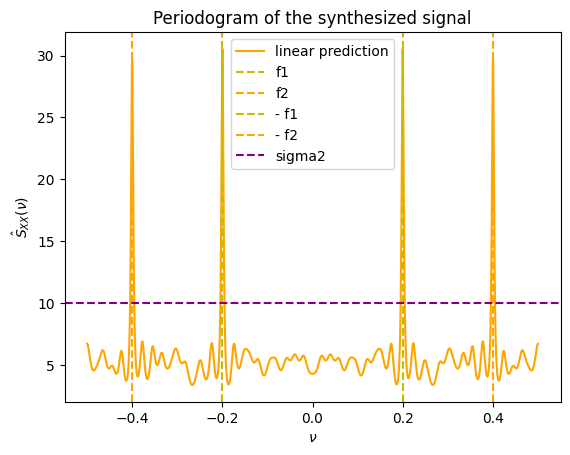

In [50]:
#periodogram of the previously synthesized signal: high noise, 2 distincts frequencies
signal_sin= synthesize_sum_sinus(N=N_sin, freqs=[0.20,0.40], amp=amp_sin, phiO=phiO_sin, sigma2=10)
ARestimation(signal_sin, freqs_sin, 10, order=50)

We can clearly notice the error in the estimation of the variance here with the noise being at the wrong level.

estimated coeffs: [ 1.00000000e+00 -1.21441999e-03  5.39312115e-02 -1.31445612e-02
 -4.66486579e-02  1.37631719e-02  5.38182098e-02 -3.90376476e-03
 -3.94110761e-02  3.27646432e-03  4.59754734e-02 -1.25944986e-02
 -5.15123059e-02  8.86117351e-03  4.17682757e-02 -1.81663626e-02
 -4.68954868e-02  5.36445891e-03  3.12475250e-02 -2.89959276e-02
 -2.41332942e-02  1.33077003e-02  6.33668885e-03 -2.14799369e-02
 -1.40228674e-02  1.61814347e-02  1.44165556e-03 -2.91900030e-02
 -2.61336862e-02  1.34172730e-02  1.04788560e-02 -2.58602542e-03
  3.75534187e-04  1.12110674e-02  5.86111861e-03  1.37005754e-02
 -1.51577380e-02  7.10426645e-03 -2.21671923e-02 -8.08999055e-03
  2.96512530e-03  1.39601904e-03  7.87953366e-03  2.39601319e-02
 -1.64009817e-04 -9.90343923e-03  1.08299746e-03  6.09179506e-03
  1.27038417e-02 -1.81823577e-02 -5.80500881e-03] estimated variance:  5.225378580326833


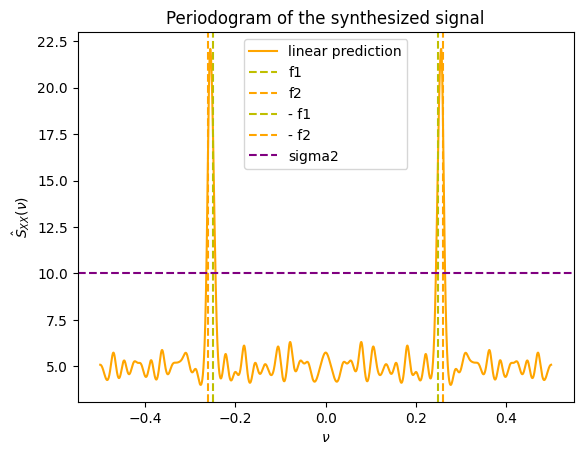

In [67]:
#periodogram of the previously synthesized signal: 2 close frequencies
ARestimation(signal_sin1, [0.25,0.26], sigma2=10, order=50)

Also with the linear prediction, we have this issue of detecting 2 too close frequencies.

**2.4**

In [68]:
def R_inverse(signal):  
    """compute the inverse of the empirical autocovariance matrix of signal"""
    
    N = signal.size
    R = np.zeros((N, N))
    col = np.convolve(signal, np.flip(signal))[-N:] / N 
    for n in range(N):
        R[n:, n] = col[:N-n]
    R += np.triu(R.T, 1)
    return np.linalg.inv(R)



def capon_estimator(signal, nu, inverseR):
    N = signal.size
    e = np.matrix([np.exp(2*1j*np.pi*nu*n) for n in range(N)])
    tmp = N / (e @ inverseR @ e.H)
    return np.abs(tmp.A[0][0])

In [76]:
def plot_capon_estimator(signal, freqs, sigma):
    N = len(signal)
    inverseR = R_inverse(signal)
    f = np.fft.fftshift(np.fft.fftfreq(N))
    capon = np.zeros_like(f)
    for i in range(len(f)):
        capon[i] = capon_estimator(signal, f[i], inverseR)
    plt.plot(f, capon, label="Capon")

    #tradé des lignes demandées
    
    plt.axvline(x=freqs[0], color='y', linestyle='--', label='f1')
    plt.axvline(x=freqs[1], color='orange', linestyle='--', label='f2')
    plt.axvline(x=-freqs[0], color='y', linestyle='--', label='- f1')
    plt.axvline(x=-freqs[1], color='orange', linestyle='--', label='- f2')
    plt.axhline(y=sigma, color='purple', linestyle='--', label='sigma2')
    
    plt.title("Capon estimator")
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\hat{S}_{XX}(\nu)$ (dB)")
    plt.legend()
    plt.show()

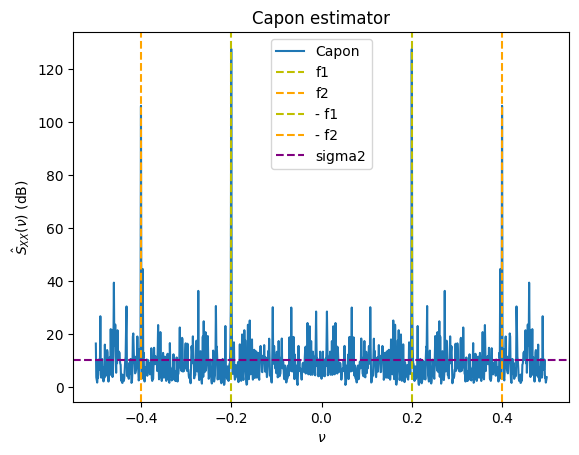

In [54]:
#plot with 2 distinct frequencies
signal_sin_prime=synthesize_sum_sinus(N=1000, freqs=[0.2,0.4], amp=amp_sin, phiO=phiO_sin, sigma2=sigma2_sin)
plot_capon_estimator(signal_sin_prime, [0.2,0.4], sigma2_sin)


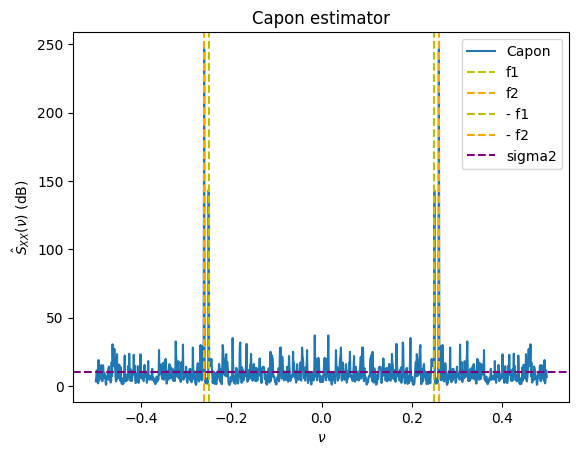

In [55]:
#plot with 2 close frequencies
signal_sin_prime=synthesize_sum_sinus(N=1000, freqs=[0.25,0.26], amp=amp_sin, phiO=phiO_sin, sigma2=sigma2_sin)
plot_capon_estimator(signal_sin_prime, [0.25,0.26], sigma2_sin)


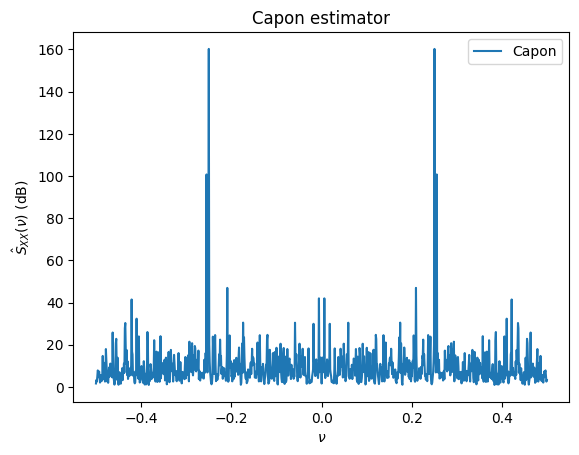

In [75]:
#plot with 2 really close frequencies
signal_sin_prime=synthesize_sum_sinus(N=1000, freqs=[0.25,0.255], amp=amp_sin, phiO=phiO_sin, sigma2=sigma2_sin)
plot_capon_estimator(signal_sin_prime, [0.25,0.255], sigma2_sin)


Capon estimator is able to detect even 2 really close frequencies, it is very precise. 

**3.1**

In [57]:
def ARMA_process(ar_coeffs, ma_coeffs, sigma2, N):

    p = len(ar_coeffs)
    q = len(ma_coeffs)
    r = max(p,q)

    sigma = np.sqrt(sigma2)

    data = np.zeros(N + 10*r)
    
    # Generate white noise
    noise = np.random.normal(0, sigma, N + 10*r)

    for t in range (0, N + 10*r): 

        if (t >= p):
            if (t >= q):
                data[t] = noise[t] + np.dot(ar_coeffs[::-1], data[t - p:t]) + np.dot(ma_coeffs[::-1], noise[t - q:t])
            else :
                data[t] = noise[t] + np.dot(ar_coeffs[::-1], data[t - p:t]) + np.dot(ma_coeffs[q - t:t:-1], data[:t])
        else: 
            if (t >= q):
                data[t] = noise[t] + np.dot(ar_coeffs[p - t:t:-1], data[:t]) + np.dot(ma_coeffs[::-1], noise[t - q:t])
            else:
                data[t] = noise[t] + np.dot(ar_coeffs[p - t:t:-1], data[:t]) + np.dot(ma_coeffs[q - t:t:-1], data[:t])

    return data[10*r:]


    

**3.2**

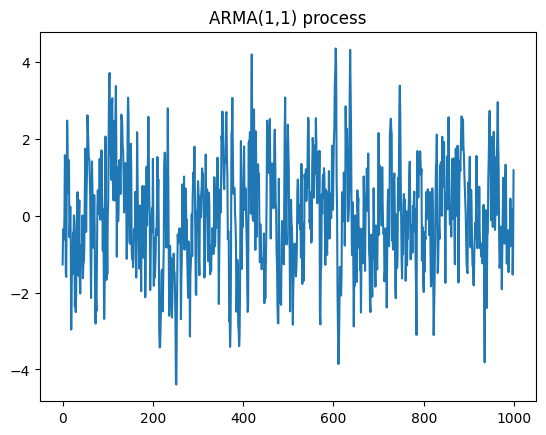

In [97]:
#def of an ARMA(1,1) process
N = 1000
ar_coeffs = np.array([0.6])
ma_coeffs = np.array([0.2])
sigma2 = 1
signal_arma = ARMA_process(ar_coeffs, ma_coeffs, sigma2, N)

plt.plot(signal_arma)
plt.title("ARMA(1,1) process")
plt.show()

the bias of the Std estimator is: 0.007074610966631464 and its variance is 13.88731834647048


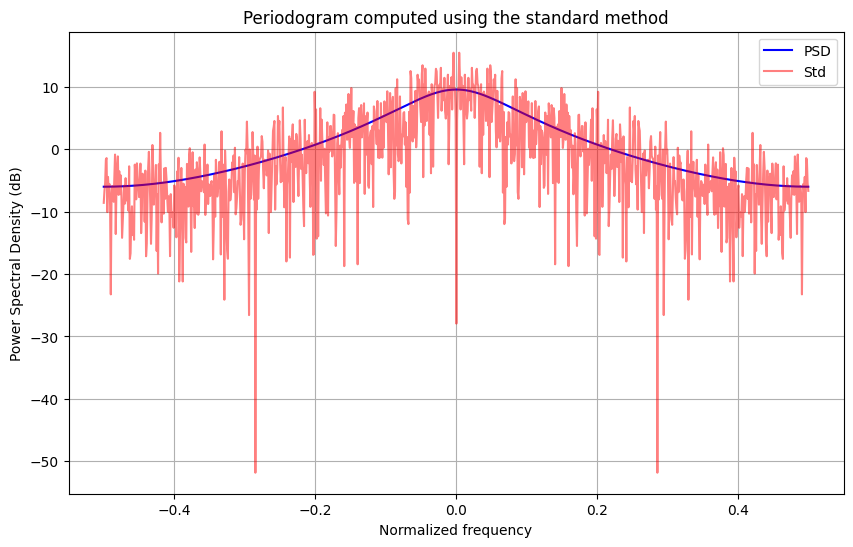

the bias of the B estimator is: 0.01773080019758363 and its variance is 6.2334093407059905


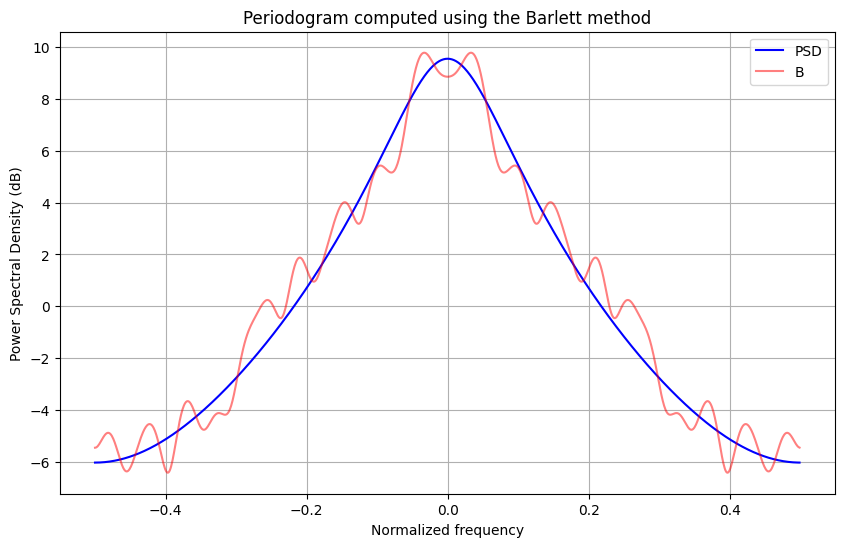

the bias of the W estimator is: -0.04212997269406127 and its variance is 6.2811227502735365


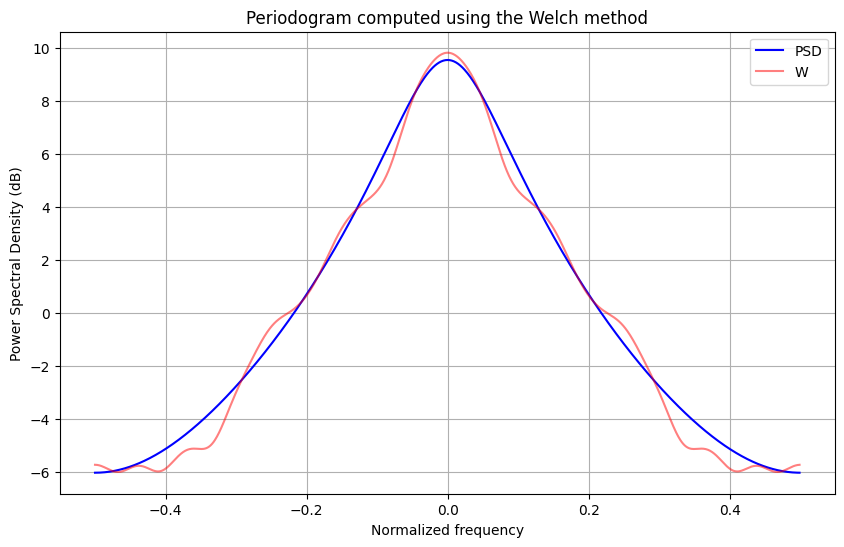

In [105]:
#plot the periodograms obtained with the different methods and the known PSD
for i in({'Std', 'B', 'W'}):
    f, Pxx = periodogram(signal_arma, method=i)

    #compute the theorical psd of the chosen ARMA process
    psd_arma =  [sigma2 * np.abs(1 + ma_coeffs[0]*np.exp(-2*1j*np.pi*nu))**2 / np.abs(1 - ar_coeffs[0]*np.exp(-2*1j*np.pi*nu))**2 for nu in f]

    visualisation(f, Pxx, method=i, psd=psd_arma)
    

The 3 estimators have almost the same bias, however Welch and Barlett estimators have a better variance.

**3.3**

In [106]:
def durbin(signal, p, q):
    """computes the estimated parameters(ar_coeffs, ma_coeffs, sigma2) of an
    ARMA(p,q) process using the Durbin method"""

    N = len(signal)

    # estimation of the AR part (modified Yule-Walker Method)
    R = np.zeros((p, p))

   
    r = np.convolve(signal, np.flip(signal))[N+q-1:N+q+p] / N 
    for n in range(p):
        R[n:, n] = r[:p-n]
    R += np.triu(R.T, 1) # fill the upper part by symmetry
    # solve the modified Yule-Walker equations
    invR = np.linalg.inv(R)
    ahat = invR @ r[1:]
    # compute sigma2_hat
    r = np.convolve(signal, np.flip(signal))[N-1:N+p] / N 
    sigma2_hat = np.abs(r[0] - np.sum(ahat*r[1:]))

    ### estimation of the MA part (Durbin method)
    ahatexp = np.concatenate(([1], -ahat))
    Y = np.convolve(signal, ahatexp)
    NY = Y.size
    L = 64*q # >> q
    RY = np.zeros((L, L))
    rY = np.convolve(Y, np.flip(Y))[NY-1:NY+L] / N
    for n in range(L):
        RY[n:, n] = rY[:L-n]
    RY += np.triu(RY.T, 1) 
    # solve the modified Yule-Walker equations
    invRY = np.linalg.inv(RY)
    ahatY = invRY @ rY[1:]

    ### compute the sequence \hat{r}_L
    r_hat_L = np.zeros(2*L+1)
    pow2 = 2**13 
    ahatexp = np.concatenate(([1], -ahatY))
    n = max(pow2, int(2**np.ceil(np.log2(ahatexp.size))))
    ft = np.abs(np.fft.fft(ahatexp, n=n))**2
    for k in range(-L, L+1):
        integrand = ft * np.cos(2*np.pi*k*np.arange(pow2)/pow2) # for the inverse Fourier transform
        r_hat_L[k] = np.sum(integrand) / pow2 # simple quadrature method integration
    
    ### estimate an AR-(q) on r_hat_L
    Nr = r_hat_L.size
    Rr = np.zeros((q, q))
    rr = np.convolve(r_hat_L, np.flip(r_hat_L))[Nr-1:Nr+q] / N 
    for n in range(q):
        Rr[n:, n] = rr[:q-n]
    Rr += np.triu(Rr.T, 1) 
    # solve the modified Yule-Walker equations
    invRr = np.linalg.inv(Rr)
    bhat = invRr @ rr[1:]
    
    return (ahat, -bhat, sigma2_hat)
    

In [107]:
#estimated parameters of our AMRA(1,1) process
ar_coeffs_est, ma_coeffs_est, sigma2_est = durbin(signal_arma, 1, 1)
print("the estimated parameters of our ARMA(1,1) process are: AR-coeffs:", ar_coeffs_est, "MA-coeffs", ma_coeffs_est, "noise variance:", sigma2_est)
print("the relative error over the coefficient estimation is:", np.mean([np.abs(ar_coeffs_est - ar_coeffs)/ar_coeffs, np.abs(ma_coeffs_est - ma_coeffs)/ma_coeffs]))

the estimated parameters of our ARMA(1,1) process are: AR-coeffs: [0.59455746] MA-coeffs [0.25636704] noise variance: 1.1701951569573725
the relative error over the coefficient estimation is: 0.1454530384690384


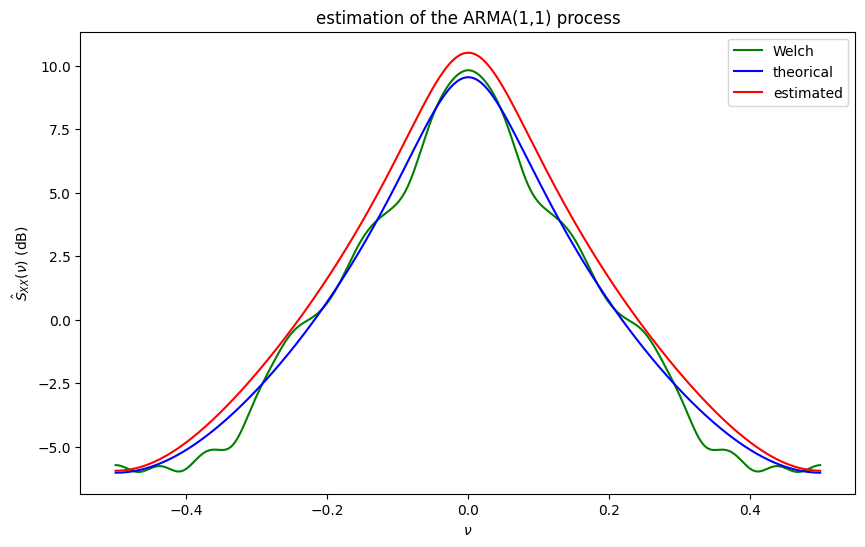

In [108]:
plt.figure(figsize=(10, 6))

#Periodram using Welch's method
f, Pxx = periodogram(signal_arma, method='W')


#theorical PSD of the ARMA process
psd_arma = np.fft.fftshift(psd_arma)

#PSD of the estimated ARMA process
psd_arma_est =  [sigma2_est * np.abs(1 + ma_coeffs_est[0]*np.exp(-2*1j*np.pi*nu))**2 / np.abs(1 - ar_coeffs_est[0]*np.exp(-2*1j*np.pi*nu))**2 for nu in f]
psd_arma_est = np.fft.fftshift(psd_arma_est)

f = np.fft.fftshift(f)
Pxx = np.fft.fftshift(Pxx)
plt.plot(f, 10*np.log10(Pxx), color='green', label="Welch")

plt.plot(f, 10*np.log10(psd_arma), color='blue', label="theorical")

plt.plot(f, 10*np.log10(psd_arma_est), color='red', label="estimated")


plt.title("estimation of the ARMA(1,1) process")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\hat{S}_{XX}(\nu)$ (dB)")
#plt.yscale("log")
plt.legend()
plt.show()

Again the bad estimation of the variance leads to the apparition of a bias in the estimated ARMA process. Still the durbin seems to be a precise method, returning a really smooth and accurate PSD estimation.

**3.4**

Forme du signal : 28270
Taux d'échantillonnage : 16000


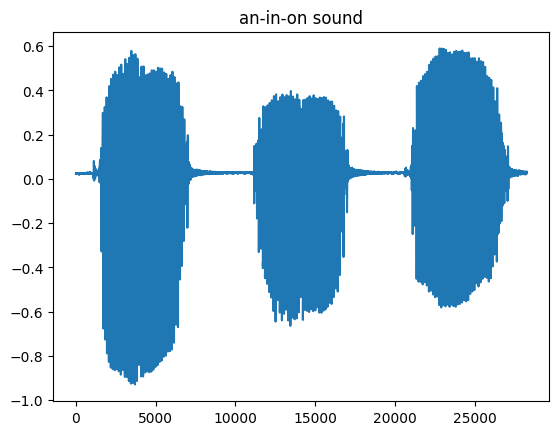

In [102]:
#Extraction du fichier audio
# Chemin vers le fichier audio
audio_file_path = r'C:\Users\jeans\Downloads\sounds\an_in_on.wav'

# Charger le fichier audio avec Librosa
audio_signal, sample_rate = librosa.load(audio_file_path, sr=None)

# Afficher la forme du signal
N = len(audio_signal)
print("Forme du signal :", N)
print("Taux d'échantillonnage :", sample_rate)

plt.plot(audio_signal)
plt.title("an-in-on sound")
plt.show()

In [103]:
#estimated parameters of the sound signal
ar_coeffs_est, ma_coeffs_est, sigma2_est = durbin(audio_signal, 1, 1)
print("the estimated parameters of our ARMA(1,1) process are: AR-coeffs:", ar_coeffs_est, "MA-coeffs", ma_coeffs_est, "noise variance:", sigma2_est)
print("the relative error over the coefficient estimation is:", np.mean([np.abs(ar_coeffs_est - ar_coeffs)/ar_coeffs, np.abs(ma_coeffs_est - ma_coeffs)/ma_coeffs]))

the estimated parameters of our ARMA(1,1) process are: AR-coeffs: [0.96138339] MA-coeffs [0.91090453] noise variance: 0.001982402056455612
the relative error over the coefficient estimation is: 2.078414148636913


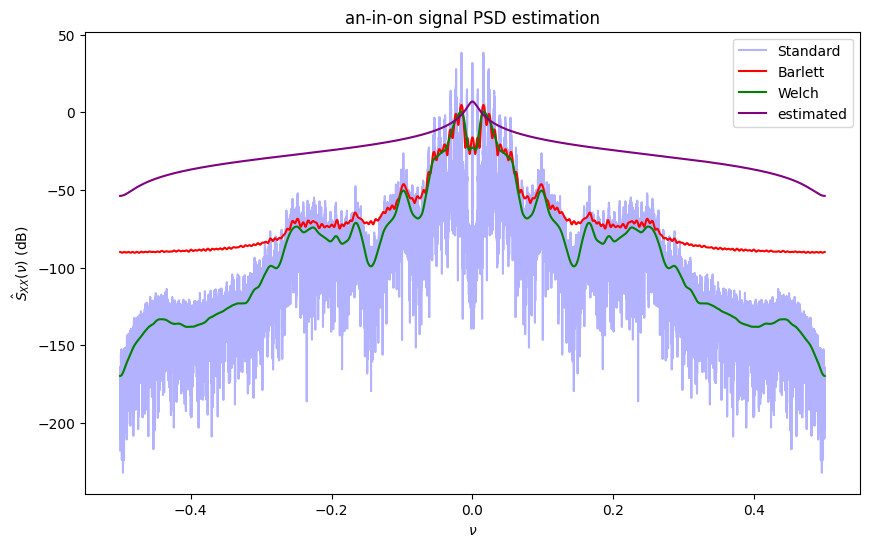

In [104]:
plt.figure(figsize=(10, 6))

#Periodogram
for i in ({'Std', 'W', 'B'}):
    f, Pxx = periodogram(audio_signal, method=i)
    f = np.fft.fftshift(f)
    Pxx = np.fft.fftshift(Pxx)
    if (i=='Std'):
        plt.plot(f, 10*np.log(Pxx), color='blue', label="Standard", alpha=0.3)
    elif (i=='W'):
        plt.plot(f, 10*np.log(Pxx), color='green', label="Welch")
    elif (i=='B'):
        plt.plot(f, 10*np.log(Pxx), color='red', label="Barlett")

#PSD of the estimated ARMA process
f = np.fft.fftfreq(N)
psd_arma_est =  [sigma2_est * np.abs(1 + ma_coeffs_est[0]*np.exp(-2*1j*np.pi*nu))**2 / np.abs(1 - ar_coeffs_est[0]*np.exp(-2*1j*np.pi*nu))**2 for nu in f]
psd_arma_est = np.fft.fftshift(psd_arma_est)
f = np.fft.fftshift(f)
plt.plot(f, 10*np.log10(psd_arma_est), color='purple', label="estimated")


plt.title("an-in-on signal PSD estimation")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\hat{S}_{XX}(\nu)$ (dB)")
#plt.yscale("log")
plt.legend()
plt.show()